# Convert Registration Transform Results to ITK

`itk-elastix` builds on tools available in the Insight Toolkit image processing ecosystem to deliver advanced registration methods. While Elastix transforms are traditionally managed as Elastix parameter maps, it is often useful to convert Elastix parameter output back to standard ITK transform types for use in larger ITK pipelines.

This notebook demonstrates how the `ElastixRegistrationMethod.ConvertToITKTransform` method may be used to convert Elastix registration results into standard ITK transform types.

In [1]:
from dataclasses import dataclass

import itk
import matplotlib.pyplot as plt

%matplotlib inline

itk.auto_progress(1)

## Load Images

For demonstration we will perform deformable registration of a moving image onto a distorted, fixed image.

In [2]:
# Load images with itk floats (itk.F). Necessary for elastix
fixed_image = itk.imread("data/CT_2D_head_fixed.mha", itk.F)
moving_image = itk.imread("data/CT_2D_head_moving.mha", itk.F)

Loading ITKPyBase... Loading ITKPyBase... Loading ITKCommon... Loading ITKCommon... Loading ITKIOImageBase... Loading ITKIOHDF5... Loading ITKIOHDF5... Loading IOOMEZarrNGFF... Loading IOOMEZarrNGFF... Loading ITKIOBMP... Loading ITKIOBMP... Loading ITKIOBioRad... Loading ITKIOBioRad... Loading ITKIOBruker... Loading ITKIOBruker... Loading ITKIOGDCM... Loading ITKIOGDCM... Loading ITKIOIPL... Loading ITKIOIPL... Loading ITKIOGE... Loading ITKIOGE... Loading ITKIOGIPL... Loading ITKIOGIPL... Loading ITKIOJPEG... Loading ITKIOJPEG... Loading ITKIOJPEG2000... Loading ITKIOJPEG2000... Loading ITKIOTIFF... Loading ITKIOTIFF... Loading ITKIOLSM... Loading ITKIOLSM... Loading ITKIOMINC... Loading ITKIOMINC... Loading ITKIOMRC... Loading ITKIOMRC... Loading ITKIOMeta... Loading ITKIOMeta... Loading ITKStatistics... Loading ITKStatistics... Loading ITKImageFilterBase... Loading ITKImageFilterBase... Loading ITKTransform... Loading ITKTransform... Loading ITKIONIFTI... Loading ITKIONIFTI... Load

Loading ITKBridgeNumPy... Loading ITKBridgeNumPy... 

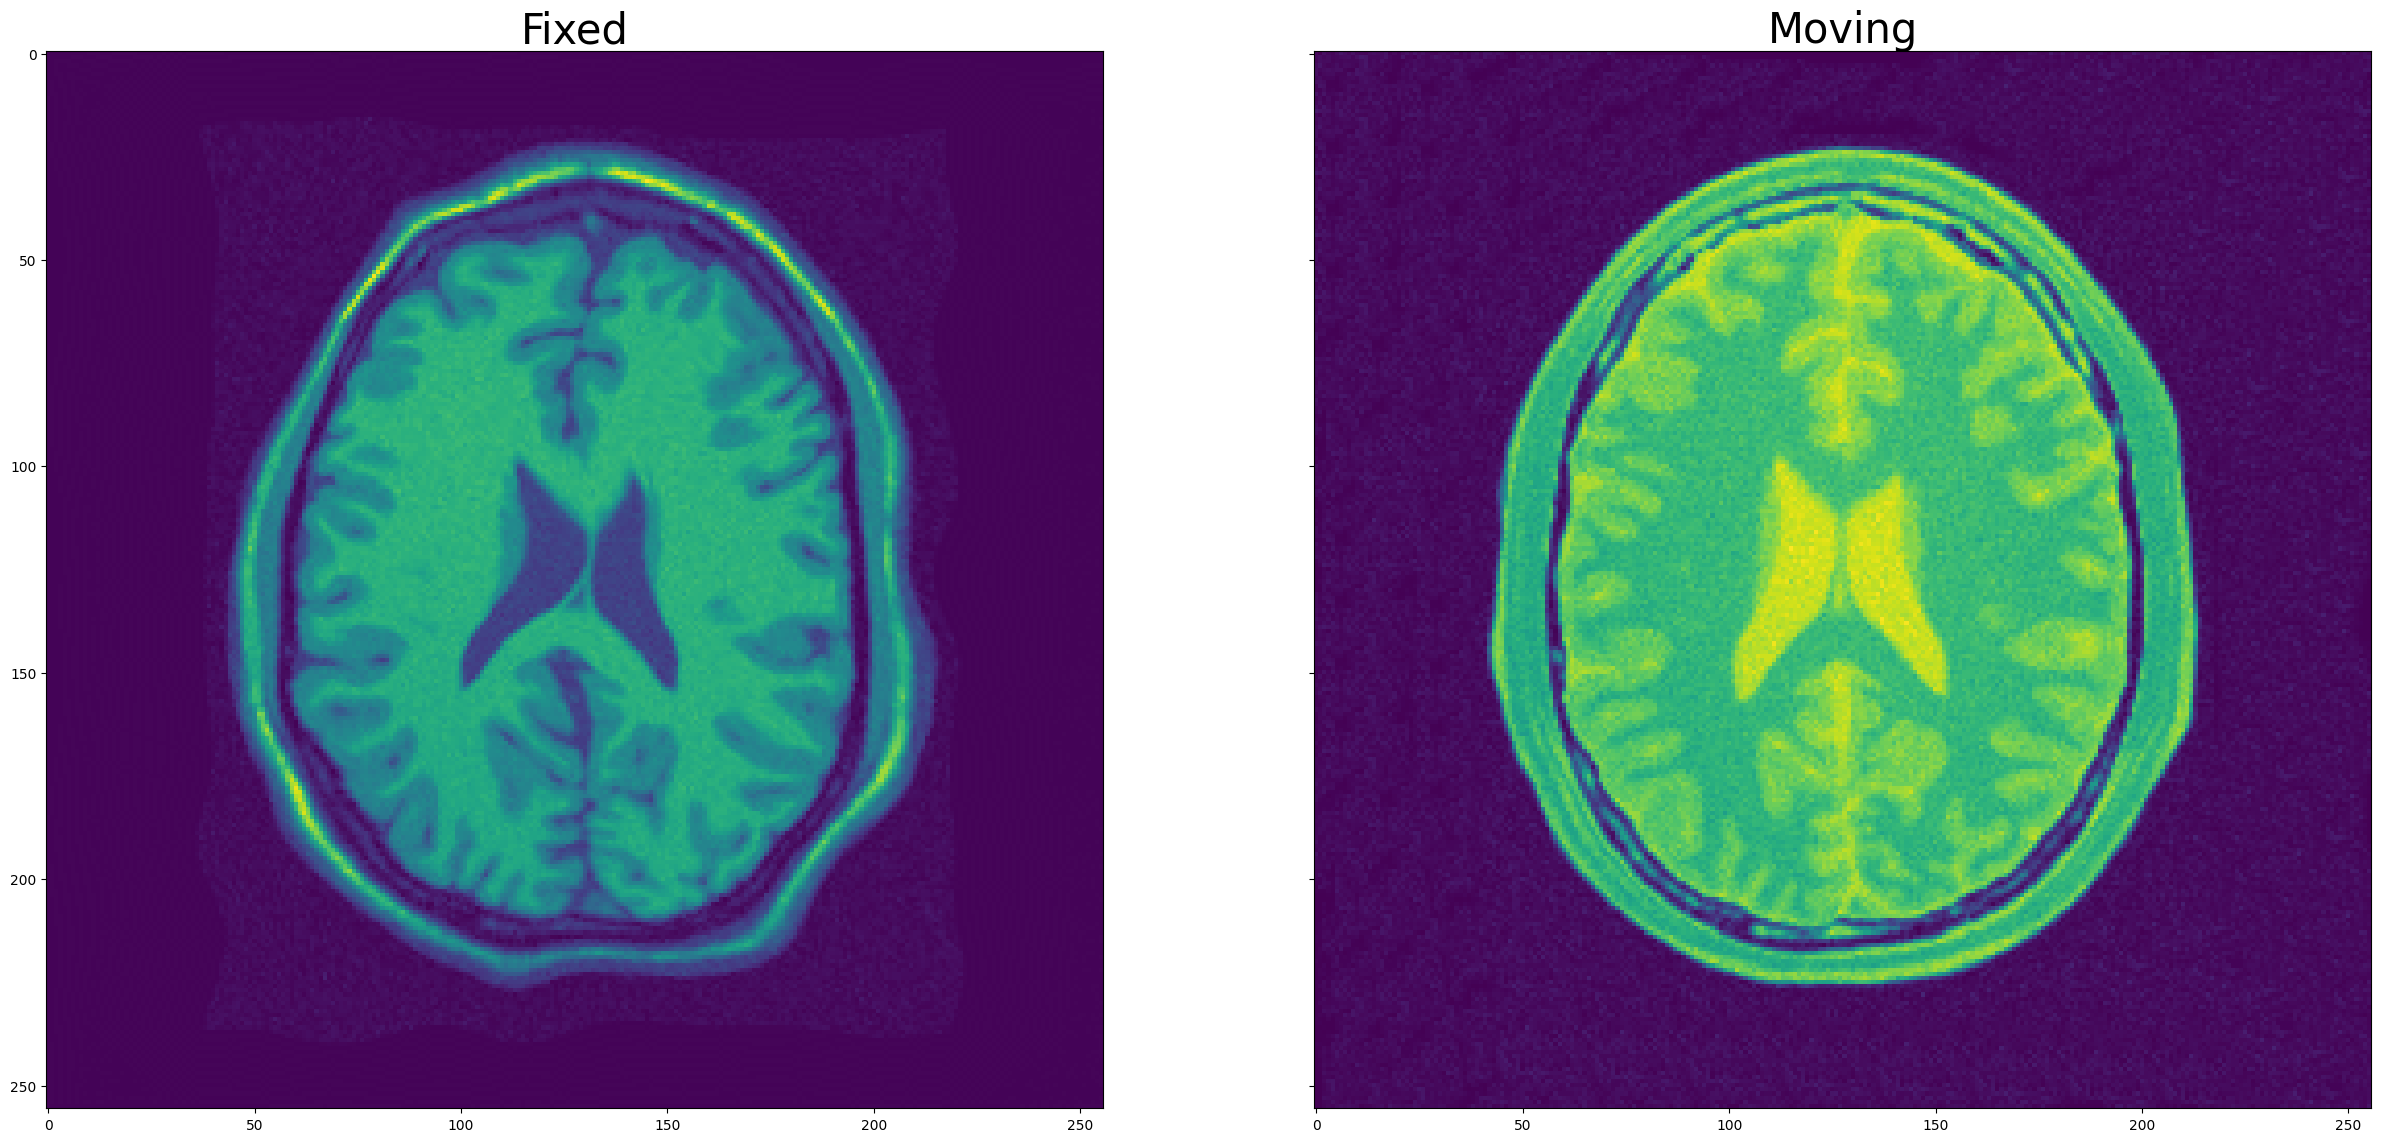

In [3]:
# Plot images
fig, axs = plt.subplots(1, 2, sharey=True, figsize=[30, 30])
plt.figsize = [100, 100]
axs[0].imshow(fixed_image)
axs[0].set_title("Fixed", fontsize=30)
axs[1].imshow(moving_image)
axs[1].set_title("Moving", fontsize=30)
plt.show()

## Set Up for Registration

We will optimize a transform relationship mapping the moving image onto the fixed image with the following stages:

1. Rigid (Euler2D) registration optimizing a global translation and rotation
2. Affine registration optimizing a global translation, rotation, scale, and shear
3. B-Spline registration optimizing local alignment with spline-based deformations

We describe each registration stage in terms of both Elastix and base ITK transforms. We will drive registration with Elastix parameter maps and convert the results to ITK transforms. For demonstration purposes we will use the default Elastix parameter map settings for each registration stage.

It is important to note that the ITK and Elastix registration process optimizes transforms that sample _from the fixed image space to the moving image space_. We expect that after registration we can move a physical point from fixed space to moving space by applying the rigid, then affine, then B-spline transform results to the point. Refer to the [ITK Software Guide](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch3.html) for further discussion.

In [4]:
# Create a container class for convenience to demonstrate Elastix/ITK transform mappings.


@dataclass
class ElastixITKTransformPair:
    """Transform representation as an Elastix parameter map preset and as an ITK transform type."""

    elastix_name: str
    itk_type: itk.Transform

In [5]:
# Set up stages of the transform schedule to optimize via image registration.

transform_schedule = [
    ElastixITKTransformPair("rigid", itk.Euler2DTransform[itk.D]),
    ElastixITKTransformPair("affine", itk.AffineTransform[itk.D, 2]),
    ElastixITKTransformPair("bspline", itk.BSplineTransform[itk.D, 2, 3]),
]

In [6]:
# Convert our transform schedule to an Elastix parameter map representation.

parameter_object = itk.ParameterObject.New()

for transform_info in transform_schedule:
    parameter_object.AddParameterMap(
        itk.ParameterObject.GetDefaultParameterMap(transform_info.elastix_name)
    )

print(parameter_object)

Loading ITKImageSources... Loading ITKImageSources... Loading ITKImageFunction... Loading ITKImageFunction... Loading ITKImageGrid... Loading ITKImageGrid... Loading ITKFFT... Loading ITKFFT... Loading ITKMesh... Loading ITKMesh... Loading ITKSpatialObjects... Loading ITKSpatialObjects... Loading ITKImageCompose... Loading ITKImageCompose... Loading ITKImageStatistics... Loading ITKImageStatistics... Loading ITKPath... Loading ITKPath... Loading ITKImageIntensity... Loading ITKImageIntensity... Loading ITKThresholding... Loading ITKThresholding... Loading ITKConvolution... Loading ITKConvolution... Loading ITKSmoothing... Loading ITKSmoothing... Loading ITKOptimizers... Loading ITKOptimizers... Loading ITKImageGradient... Loading ITKImageGradient... Loading ITKImageFeature... Loading ITKImageFeature... Loading ITKFiniteDifference... Loading ITKFiniteDifference... Loading ITKDisplacementField... Loading ITKDisplacementField... Loading ITKRegistrationCommon... 

ParameterObject (00000157F6B98310)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 67
  Debug: Off
  Object Name: 
  Observers: 
    ProgressEvent(PyCommand)
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (AutomaticScalesEstimation "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 3)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (ImageSampler "RandomCoordinate")
  (Interpolator "LinearInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImagePyramid "MovingSmoothingImagePyramid")
  (NewSamplesEveryIteration "true")
  (NumberOfResolutions 4)
  (NumberOfSamplesForExactGradient 4096)
  (NumberOfSpatialSamples 2048)
  (Optimizer "AdaptiveStochasticGradientDescent")
  (Registration "MultiResolutionRegistration")
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (

Loading ITKRegistrationCommon... Loading ITKVoronoi... Loading ITKVoronoi... Loading ITKQuadEdgeMesh... Loading ITKQuadEdgeMesh... Loading ITKIOMeshBase... Loading ITKIOMeshBYU... Loading ITKIOMeshBYU... Loading ITKIOMeshFreeSurfer... Loading ITKIOMeshFreeSurfer... Loading ITKIOMeshGifti... Loading ITKIOMeshGifti... Loading ITKIOMeshOBJ... Loading ITKIOMeshOBJ... Loading ITKIOMeshOFF... Loading ITKIOMeshOFF... Loading ITKIOMeshVTK... Loading ITKIOMeshVTK... Loading ITKIOMeshBase... Loading Elastix... Loading Elastix... 

## Run Registration

Run Elastix registration over each of the three transform stages.

In [7]:
# Set up the registration method.
# We retain a handle to the `registration_method` object for subsequent transform output conversion methods.

registration_method_type = itk.ElastixRegistrationMethod[
    type(fixed_image), type(moving_image)
]
registration_method = registration_method_type.New(
    fixed_image=fixed_image,
    moving_image=moving_image,
    parameter_object=parameter_object,
)

In [8]:
registration_method.Update()

In [9]:
elx_result_image = registration_method.GetOutput()

## Get Registration Results in ITK Format

Now that registration has run we can convert our results to ITK transform format according to the transform schedule we previously defined. The result is an `itk.CompositeTransform` object that organizes successive transform stages into a single object for easier use and maintenance.

`itk.CompositeTransform` makes the following assumptions:
1. Transforms map from the fixed image to the moving image. That is, we can apply the composite transform to a physical point in the fixed image to get a physical point in the moving image.
2. Transforms should be applied in reverse order. To transform a physical point from the fixed to moving image, first apply the last (`N-1`) transform, then apply the next transform (`N-2`), and so on until the first transform at position `0`.

Refer to the [ITK Software Guide](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch3.html) for more information.


In [10]:
elx_advanced_transform = registration_method.GetCombinationTransform()
itk_composite_transform = itk.CompositeTransform[itk.D, 2].cast(
    registration_method.ConvertToItkTransform(elx_advanced_transform)
)
print(itk_composite_transform)

CompositeTransform (00000157F7F2A540)
  RTTI typeinfo:   class itk::CompositeTransform<double,2>
  Reference Count: 1
  Modified Time: 121631
  Debug: Off
  Object Name: 
  Observers: 
    none
  TransformQueue: 
  >>>>>>>>>
  BSplineTransform (00000157EE15AB30)
    RTTI typeinfo:   class itk::BSplineTransform<double,2,3>
    Reference Count: 1
    Modified Time: 121618
    Debug: Off
    Object Name: 
    Observers: 
      none
    CoefficientImage: [ 00000157F7E72930, 00000157F7E6F2D0 ]
    TransformDomainOrigin: [-3.54546, -4.3805]
    TransformDomainPhysicalDimensions: [259.799, 263.474]
    TransformDomainDirection: 1 0
0 1

    TransformDomainMeshSize: [26, 26]
    GridSize: [29, 29]
    GridOrigin: [-13.5377, -14.5141]
    GridSpacing: [9.99227, 10.1336]
    GridDirection: 1 0
0 1

  >>>>>>>>>
  AffineTransform (00000157F66561F0)
    RTTI typeinfo:   class itk::AffineTransform<double,2>
    Reference Count: 1
    Modified Time: 121624
    Debug: Off
    Object Name: 
    Observe

In [11]:
# Validate resulting transform types match our input registration schedule.
# Note that the order of transforms in `itk.CompositeTransform` is reversed
for index, transform_type in enumerate(transform_schedule[::-1]):
    try:
        transform_type.itk_type.cast(itk_composite_transform.GetNthTransform(index))
    except RuntimeError as e:
        print(
            f"Could not cast stage {index} from {itk_composite_transform.GetNthTransform(index).GetNameOfClass()} to {transform_type.itk_type}"
        )
        raise e

In [12]:
# Save results to disk
OUTPUT_TRANSFORM_FILEPATH = "exampleoutput/itk_composite_transform.h5"
itk.transformwrite(
    [itk_composite_transform],
    OUTPUT_TRANSFORM_FILEPATH,
    compression=True,
)
print(itk.transformread(OUTPUT_TRANSFORM_FILEPATH)[0].GetNameOfClass())

CompositeTransform


Loading ITKIOTransformBase... Loading ITKIOTransformHDF5... Loading ITKIOTransformHDF5... Loading ITKIOTransformInsightLegacy... Loading ITKIOTransformInsightLegacy... Loading ITKIOTransformMatlab... Loading ITKIOTransformMatlab... Loading ITKIOTransformBase... 

## Visualize Registration Results

We apply the resulting `itk.CompositeTransform` representing registration results and compare the resulting image with the fixed and moving input images. We can see that the moving image has been deformed to align with the fixed image.

In [13]:
itk.auto_progress(0)
itk_result_image = itk.resample_image_filter(
    moving_image,
    transform=itk_composite_transform,
    use_reference_image=True,
    reference_image=fixed_image,
)

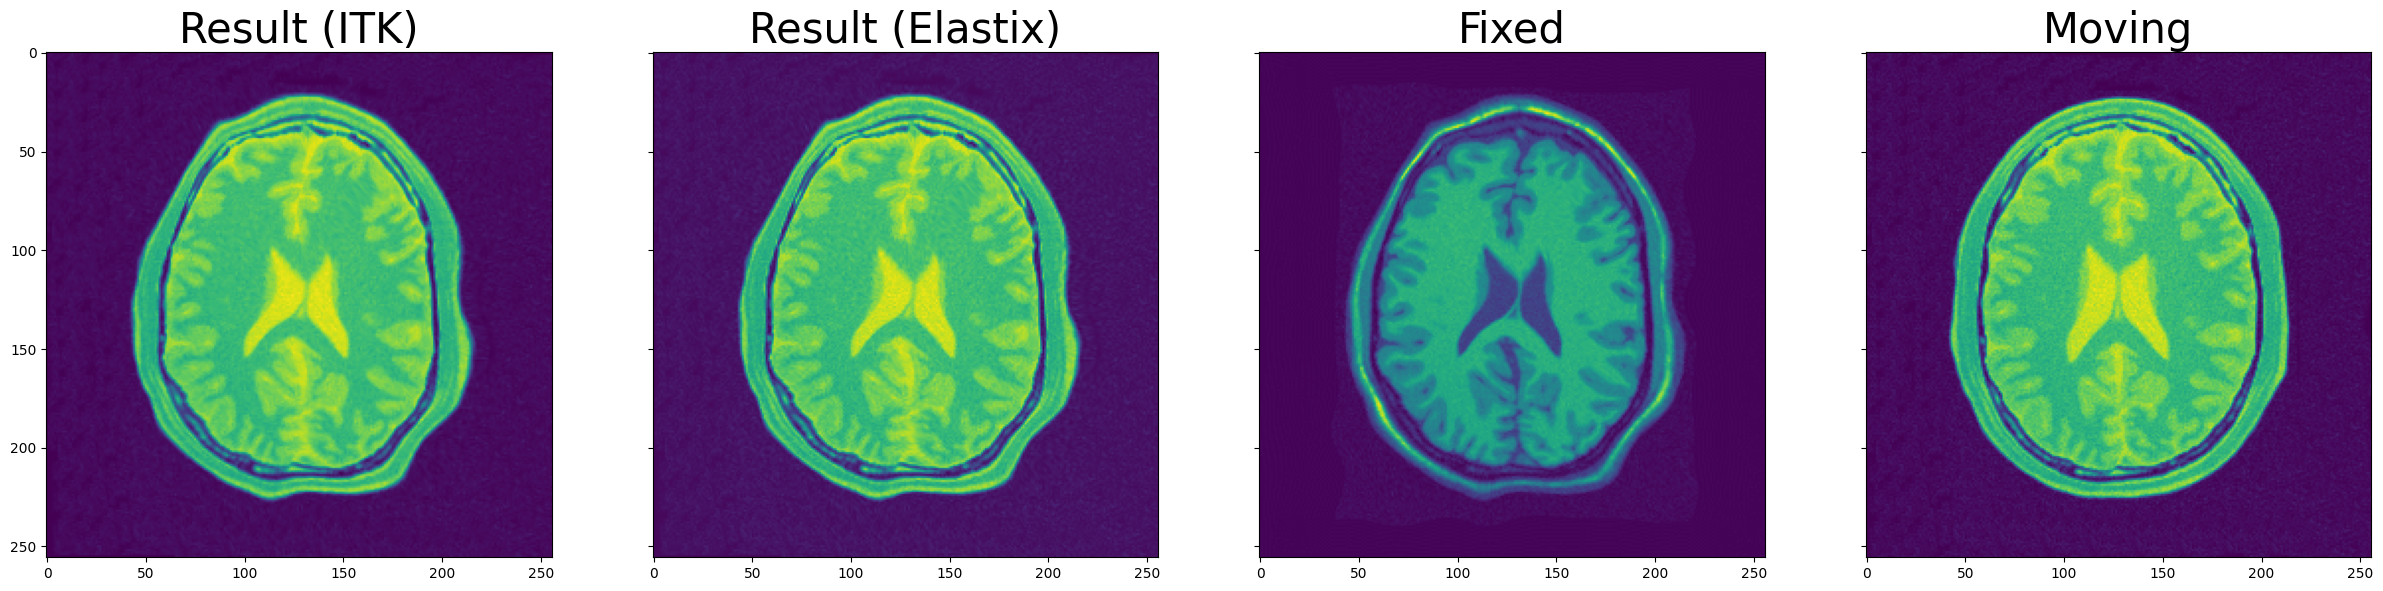

In [14]:
# Plot images
fig, axs = plt.subplots(1, 4, sharey=True, figsize=[30, 30])
plt.figsize = [100, 100]
axs[0].imshow(itk_result_image)
axs[0].set_title("Result (ITK)", fontsize=30)
axs[1].imshow(elx_result_image)
axs[1].set_title("Result (Elastix)", fontsize=30)
axs[2].imshow(fixed_image)
axs[2].set_title("Fixed", fontsize=30)
axs[3].imshow(moving_image)
axs[3].set_title("Moving", fontsize=30)
plt.show()

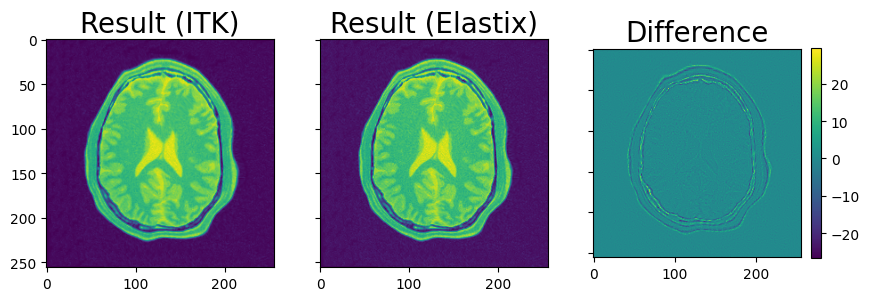

In [15]:
# Compare ITK and Elastix resampling.
# Some differences exist in default interpolation methods.

import numpy as np

# Plot images
fig, axs = plt.subplots(1, 3, sharey=True, figsize=[10, 4])
# plt.figsize=[100,100]
axs[0].imshow(itk_result_image)
axs[0].set_title("Result (ITK)", fontsize=20)
axs[1].imshow(elx_result_image)
axs[1].set_title("Result (Elastix)", fontsize=20)
diff_arr = itk.array_from_image(itk_result_image) - itk.array_from_image(
    elx_result_image
)
im = axs[2].imshow(diff_arr)
axs[2].set_title("Difference", fontsize=20)

fig.colorbar(im, orientation="vertical", pad=0.04, fraction=0.046)
plt.show()